In [1]:
from gurobipy import *
import gurobipy as gp

# type declaration
from typing import Dict, List


import pandas as pd

import numpy as np

%load_ext nb_black
%load_ext lab_black

import seaborn as sns

# importing package
import matplotlib.pyplot as plt

%matplotlib inline


import stargazer

<IPython.core.display.Javascript object>

In [2]:
import random

random.seed(42)

<IPython.core.display.Javascript object>

# Q1

In [3]:
dict_swimmers = {
    ("N", "BA"): 40.1,
    ("N", "BR"): 41.7,
    ("N", "BU"): 41.1,
    ("N", "FR"): 33.3,
    ("M", "BA"): 39.6,
    ("M", "BR"): 37.6,
    ("M", "BU"): 31.9,
    ("M", "FR"): 31.2,
    ("L", "BA"): 35.3,
    ("L", "BR"): 37.9,
    ("L", "BU"): 36.2,
    ("L", "FR"): 33.1,
    ("A", "BA"): 30.6,
    ("A", "BR"): 34.1,
    ("A", "BU"): 33.3,
    ("A", "FR"): 29.1,
    ("C", "BA"): 36.9,
    ("C", "BR"): 37.2,
    ("C", "BU"): 29.0,
    ("C", "FR"): 31.6,
}

dict_swimmers_obj = [
    ("N", "BA"),
    ("N", "BR"),
    ("N", "BU"),
    ("N", "FR"),
    ("M", "BA"),
    ("M", "BR"),
    ("M", "BU"),
    ("M", "FR"),
    ("L", "BA"),
    ("L", "BR"),
    ("L", "BU"),
    ("L", "FR"),
    ("A", "BA"),
    ("A", "BR"),
    ("A", "BU"),
    ("A", "FR"),
    ("C", "BA"),
    ("C", "BR"),
    ("C", "BU"),
    ("C", "FR"),
]
names_list = ["N", "M", "L", "A", "C"]
types_lanes = ["BA", "BR", "BU", "FR"]

<IPython.core.display.Javascript object>

In [4]:
random.seed(42)
model = Model()
x = model.addVars(dict_swimmers, obj=dict_swimmers, vtype=GRB.BINARY, name="swimmers")
model.ModelSense = gp.GRB.MINIMIZE

model.addConstrs(gp.quicksum((x[(i, j)] for j in types_lanes)) <= 1 for i in names_list)

for j in types_lanes:
    model.addConstr(gp.quicksum((x[(i, j)] for i in names_list)) == 1)

model.optimize()
print("optimal value", model.objval)
model.printAttr("X")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 9 rows, 20 columns and 40 nonzeros
Model fingerprint: 0x69b34e51
Variable types: 0 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 136.3000000
Presolve time: 0.00s
Presolved: 9 rows, 20 columns, 40 nonzeros
Variable types: 0 continuous, 20 integer (20 binary)
Found heuristic solution: objective 135.8000000

Root relaxation: objective 1.287000e+02, 8 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work


<IPython.core.display.Javascript object>

# Q2a Standard Capacity allocation problem

Use simulation to determine the optimal booking policy to maximize expected revenue: for every booking limit between 20 and 80, simulate 10000 paths and compute the expected revenue. Plot the expected revenue as a function of the booking limit. (30 points)





In [5]:
random.seed(42)
booklimit = list(range(20, 81))
lam_customerP1 = np.random.poisson(lam=75, size=10000)
lam_customerP2 = np.random.poisson(lam=50, size=10000)

profit = []
for lim in booklimit:
    salePeriod1 = np.where(lam_customerP1 <= lim, lam_customerP1, lim)
    ticketsLeft = 100 - salePeriod1
    salePeriod2 = np.where(lam_customerP2 > ticketsLeft, ticketsLeft, lam_customerP2)
    revenues = 150 * salePeriod1 + 500 * salePeriod2
    profit.append([lim, np.mean(revenues)])

<IPython.core.display.Javascript object>

In [6]:
df_profit = pd.DataFrame(profit, columns=["Alpha", "Expected Revenue"])

<IPython.core.display.Javascript object>

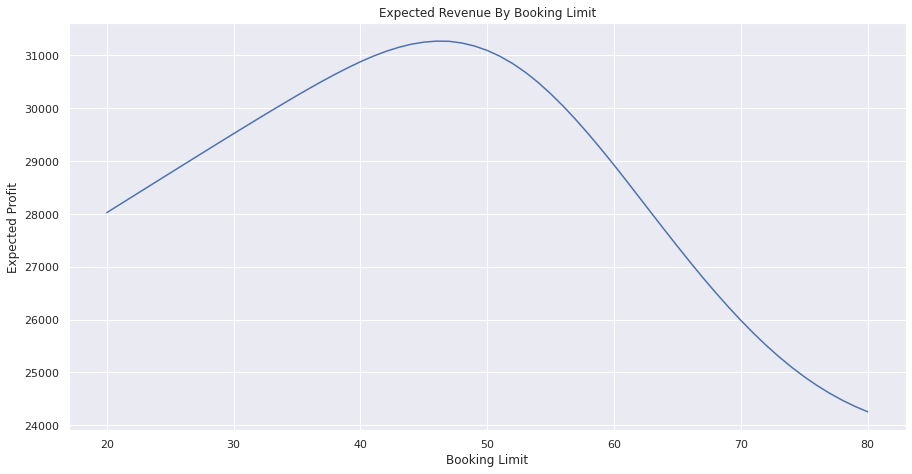

<IPython.core.display.Javascript object>

In [7]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(15, 7.5))
plt.plot(df_profit["Alpha"], df_profit["Expected Revenue"], label="line 1")
plt.title("Expected Revenue By Booking Limit")
plt.xlabel("Booking Limit")
plt.ylabel("Expected Profit")

plt.show()

In [8]:
df_profit.sort_values(by="Expected Revenue", ascending=False)

,Alpha,Expected Revenue
26,46,31269.900
27,47,31266.550
25,45,31250.750
28,48,31234.585
24,44,31211.100
...,...,...
56,76,24754.535
57,77,24606.380
58,78,24474.430
59,79,24357.705


<IPython.core.display.Javascript object>

# Q2b

In [9]:
lam_customerP1 = np.random.poisson(lam=75, size=10000)
lam_customerP2 = np.random.poisson(lam=50, size=10000)
price_range = list(range(150, 301))
booking_limit = list(range(20, 81))


profit = []
for alpha in booking_limit:
    for prp in price_range:
        # draw customer numbers period 1
        paying_customers_p1 = np.where(lam_customerP1 <= alpha, lam_customerP1, alpha)

        # define the number of seats available after period 1 sales
        n_seats = 100 - paying_customers_p1

        # Define the shortage in saeats based on period 2 demans
        period2_shortage = np.where(
            n_seats < lam_customerP2, lam_customerP2 - n_seats, 0
        )

        # draw how many custoemrs want to be refunded
        refunded = np.random.binomial(paying_customers_p1, ((prp - 150) / 150), 10000)
        period1_refunds = np.where(
            refunded >= period2_shortage, period2_shortage, refunded
        )

        # fetch the number of seats
        n_seats_new = n_seats + period1_refunds

        # paying_customers_p1 -= period1_refunds

        paying_customers_p2 = np.where(
            lam_customerP2 > n_seats_new, n_seats_new, lam_customerP2
        )

        # expected revenue
        exprevenue = (
            ((paying_customers_p1 - period1_refunds) * 150) - (period1_refunds * prp)
        ) + (paying_customers_p2 * 500)

        # save the results
        profit.append([alpha, prp, np.mean(exprevenue)])

<IPython.core.display.Javascript object>

In [10]:
df_profit_2 = pd.DataFrame(
    profit, columns=["Alpha", "Refunded Tickets", "Expected Revenue"]
)

df_profit_2_max = df_profit_2.loc[
    df_profit_2.groupby(["Alpha"])["Expected Revenue"].idxmax()
]


df_profit_2_min = df_profit_2.loc[
    df_profit_2.groupby(["Alpha"])["Expected Revenue"].idxmin()
]

<IPython.core.display.Javascript object>

In [11]:
df_profit_2_max.rename(
    columns={
        "Expected Revenue": "Expected Revenue max",
        "Refunded Tickets": "Refunded Tickets max",
    },
    inplace=True,
)

<IPython.core.display.Javascript object>

In [12]:
df_profit_2_min.rename(
    columns={
        "Expected Revenue": "Expected Revenue min",
        "Refunded Tickets": "Refunded Tickets min",
    },
    inplace=True,
)

<IPython.core.display.Javascript object>

In [13]:
df_profit_2_min

,Alpha,Refunded Tickets min,Expected Revenue min
0,20,150,27996.600
151,21,150,28146.550
302,22,150,28296.450
453,23,150,28446.250
604,24,150,28596.000
...,...,...,...
8456,76,150,24760.085
8607,77,150,24612.820
8758,78,150,24480.765
8909,79,150,24362.920


<IPython.core.display.Javascript object>

In [14]:
df_profit_2_max.sort_values(by="Expected Revenue max", ascending=False)

,Alpha,Refunded Tickets max,Expected Revenue max
4419,49,190,31533.6840
4264,48,186,31525.9938
4568,50,188,31523.2942
4114,47,187,31499.1966
4719,51,188,31491.9540
...,...,...,...
8511,76,205,27714.6195
8662,77,205,27611.2170
8814,78,206,27519.8418
8965,79,206,27436.0384


<IPython.core.display.Javascript object>

In [15]:
df_profit_2_min.sort_values(by="Expected Revenue min", ascending=False)

,Alpha,Refunded Tickets min,Expected Revenue min
3926,46,150,31258.800
4077,47,150,31257.435
3775,45,150,31236.900
4228,48,150,31230.925
3624,44,150,31193.500
...,...,...,...
8456,76,150,24760.085
8607,77,150,24612.820
8758,78,150,24480.765
8909,79,150,24362.920


<IPython.core.display.Javascript object>

In [16]:
tmp = pd.merge(
    left=df_profit,
    right=df_profit_2_max,
    left_on="Alpha",
    right_on="Alpha",
    how="inner",
)

tmp = pd.merge(
    left=tmp,
    right=df_profit_2_min,
    left_on="Alpha",
    right_on="Alpha",
    how="inner",
)


tmp["callable_products_scheme_value_max_case"] = (
    tmp["Expected Revenue max"] - tmp["Expected Revenue"]
)

tmp["callable_products_scheme_value_min_case"] = (
    tmp["Expected Revenue min"] - tmp["Expected Revenue"]
)

<IPython.core.display.Javascript object>

In [17]:
tmp["callable_products_scheme_value"] = tmp["Expected Revenue max"] - abs(
    tmp["Expected Revenue"]
)

<IPython.core.display.Javascript object>

In [18]:
tmp.callable_products_scheme_value.sum()

61151.812200000015

<IPython.core.display.Javascript object>

In [19]:
df_profit_2_max

,Alpha,Refunded Tickets max,Expected Revenue max
9,20,159,27996.6573
166,21,165,28146.6240
319,22,167,28296.5598
481,23,178,28446.4220
638,24,184,28596.2490
...,...,...,...
8511,76,205,27714.6195
8662,77,205,27611.2170
8814,78,206,27519.8418
8965,79,206,27436.0384


<IPython.core.display.Javascript object>

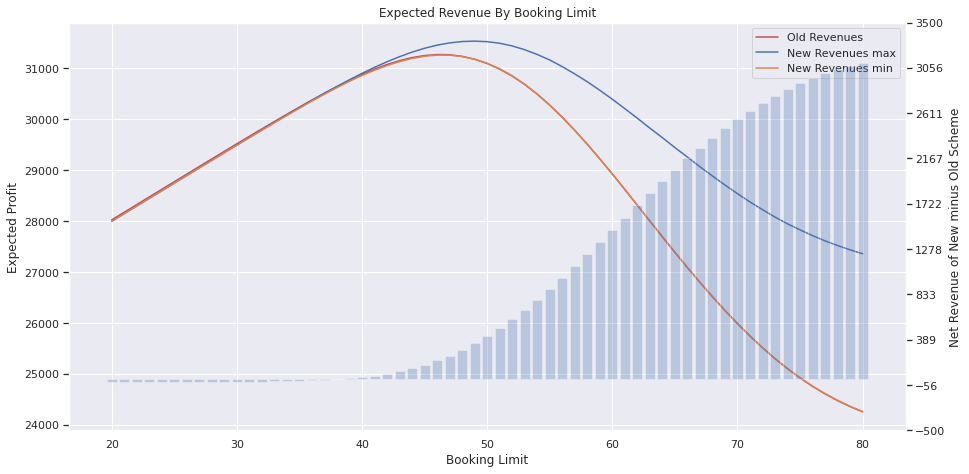

<IPython.core.display.Javascript object>

In [20]:
fig, ax = plt.subplots(figsize=(15, 7.5))
sns.set_theme()
ax2 = ax.twinx()
ax.plot(df_profit["Alpha"], df_profit["Expected Revenue"], label="Old Revenues", c="r")
ax.plot(
    df_profit_2_max["Alpha"],
    df_profit_2_max["Expected Revenue max"],
    label="New Revenues max",
)
ax.plot(
    df_profit_2_min["Alpha"],
    df_profit_2_min["Expected Revenue min"],
    label="New Revenues min",
)

ax2.bar(
    tmp["Alpha"],
    tmp["callable_products_scheme_value_max_case"],
    label="Value of Scheme",
    alpha=0.3,
)

ax2.set_yticks(
    np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks()))
)
ax2.grid(False)
plt.title("Expected Revenue By Booking Limit")
ax.set_xlabel("Booking Limit")
ax.set_ylabel("Expected Profit")
ax2.set_ylabel("Net Revenue of New minus Old Scheme")
ax.legend()
plt.show()

## q3 A

In [21]:
Scenario = ["A", "B", "C"]
distros = (1, 2, 3, 4)
Warehouse = ("W_A", "W_B")

prob_scenario = {"A": 0.3, "B": 0.2, "C": 0.5}
warehouse_pf = {"W_A": 1, "W_B": 1.5}


Demand = {
    ("A", 1): 5,
    ("A", 2): 3,
    ("A", 3): 7.8,
    ("A", 4): 4,
    ("B", 1): 3,
    ("B", 2): 1,
    ("B", 3): 6,
    ("B", 4): 3,
    ("C", 1): 4.2,
    ("C", 2): 4.1,
    ("C", 3): 3,
    ("C", 4): 5.4,
}
Transportation_Costs = {
    ("W_A", 1): 1.5,
    ("W_A", 2): 2,
    ("W_A", 3): 2,
    ("W_A", 4): 3,
    ("W_B", 1): 2,
    ("W_B", 2): 1.2,
    ("W_B", 3): 1.1,
    ("W_B", 4): 2.5,
}


model = gp.Model()
model.ModelSense = gp.GRB.MAXIMIZE

# Frist stage model definition
x = model.addVars(Warehouse, vtype=gp.GRB.INTEGER, name="Product_input")

# SecondStageModel Definition
# define the varaibles
# inventory at distribution center given a scenario
sold_distributionc = model.addVars(distros, Scenario, vtype=gp.GRB.INTEGER, name="Sold")
# inventory at distribution
inv_distributionc = model.addVars(
    distros, Scenario, vtype=gp.GRB.INTEGER, name="Inventory"
)
# distribution from any warehouse to any distribution center given a scenario demand
dist_ware_scen = model.addVars(
    Warehouse, distros, Scenario, vtype=gp.GRB.INTEGER, name="Transport"
)

# set the obkjectvie for a sale price of 20 per distribution center and a 10 bucks cost per product
model.setObjective(
    gp.quicksum(
        20 * prob_scenario[scenario] * sold_distributionc[distro, scenario]
        for scenario in Scenario
        for distro in distros
    )
    # quantitiess costs for production facilties
    - gp.quicksum(
        x[warehouse] * (10 + warehouse_pf[warehouse]) for warehouse in Warehouse
    )
    # probability, distribuion, and from warehouse
    - gp.quicksum(
        dist_ware_scen[warehouse, distro, scenario]
        * Transportation_Costs[warehouse, distro]
        * prob_scenario[scenario]
        for scenario in Scenario
        for warehouse in Warehouse
        for distro in distros
    )
)

# a distibution can only send what it receives
model.addConstrs(
    (
        inv_distributionc[distro, scenario]
        == gp.quicksum(
            dist_ware_scen[warehouse, distro, scenario] for warehouse in Warehouse
        )
        for distro in distros
        for scenario in Scenario
    ),
    name="SendReceiveLimit",
)

# Any distibution centreer can only reveive as much as it reveicves from warehouse in give distribution
model.addConstrs(
    (
        gp.quicksum(dist_ware_scen[warehouse, distro, scenario] for distro in distros)
        <= x[warehouse]
        for warehouse in Warehouse
        for scenario in Scenario
    ),
    name="ReceiveConstrain",
)

# Distrobs can only sale based on a given demand based on a given scenario
model.addConstrs(
    (
        sold_distributionc[distro, scenario] <= Demand[scenario, distro] * 1000
        for distro in distros
        for scenario in Scenario
    ),
    name="SaleConstrain",
)

# Distros can only sale what is in the inventory based on a given scenario
model.addConstrs(
    (
        sold_distributionc[distro, scenario] <= inv_distributionc[distro, scenario]
        for distro in distros
        for scenario in Scenario
    ),
    name="SaleConstrain",
)

model.optimize()
print("Optimal Value:", model.Objval)
model.printAttr("X")

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 42 rows, 50 columns and 102 nonzeros
Model fingerprint: 0x9181b20e
Variable types: 0 continuous, 50 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 8e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 24 rows and 12 columns
Presolve time: 0.00s
Presolved: 18 rows, 38 columns, 66 nonzeros
Variable types: 0 continuous, 38 integer (0 binary)

Root relaxation: objective 1.049990e+05, 15 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0        

<IPython.core.display.Javascript object>

## q3 b

#### B1 & B2

In [22]:
TransportationCosts = pd.read_csv(
    "/home/angelo/Documents/Uni/Courses/Management Science/MS_Code_repo/data/TranportationCosts.csv",
    encoding="latin-1",
)
Demand = pd.read_csv(
    "/home/angelo/Documents/Uni/Courses/Management Science/MS_Code_repo/data/demand.csv",
    encoding="latin-1",
)

Scenario = Demand.columns[1:].to_list()
Scenario_Probabilities = dict(zip(Scenario, [1 / 100] * 100))


Distro = Demand.loc[:, "DistributionCenter"].to_list()
Warehouse = TransportationCosts.loc[:, "Warehouse"].to_list()


demand = {}
for distro in range(0, len(Demand)):
    for scene in range(1, len(Demand.columns)):
        demand[(Distro[distro], Scenario[scene - 1])] = Demand.loc[
            distro, Scenario[scene - 1]
        ]


Trasnportation_Costs = {}
for warehouse in range(0, len(TransportationCosts)):
    for distro in range(2, len(TransportationCosts.columns)):
        Trasnportation_Costs[
            (Warehouse[warehouse], Distro[distro - 2])
        ] = TransportationCosts.loc[warehouse, Distro[distro - 2]]


Transport_Warehouse = {}
for warehouse in range(0, len(TransportationCosts)):
    Transport_Warehouse[Warehouse[warehouse]] = TransportationCosts.loc[
        warehouse, "PFacility"
    ]

# init the mdoel
model = gp.Model()
model.ModelSense = gp.GRB.MAXIMIZE

# first stage
WareHProd_mod = model.addVars(Warehouse, vtype=gp.GRB.INTEGER, name="Production")
WareHInv_mod = model.addVars(Warehouse, vtype=gp.GRB.BINARY, name="Investment")

# second stage
dist_ware_scen = model.addVars(
    Warehouse, Distro, Scenario, vtype=gp.GRB.INTEGER, name="Transportation"
)


# products demand at distribution center given scenario
sold_distributioncentrer = model.addVars(
    Distro, Scenario, vtype=gp.GRB.INTEGER, name="Sold"
)

# Inventory at distribution for a given scenario
Inventory_Distr = model.addVars(
    Distro, Scenario, vtype=gp.GRB.INTEGER, name="Inventory"
)


model.setObjective(
    gp.quicksum(
        # Profit definition
        20 * Scenario_Probabilities[scene] * sold_distributioncentrer[distro, scene]
        for distro in Distro
        for scene in Scenario
    )
    - gp.quicksum(
        # warehousehozse and transport costs and production octs
        WareHProd_mod[warehouse] * (10 + Transport_Warehouse[warehouse])
        for warehouse in Warehouse
    )
    # fixed costs etc
    - gp.quicksum(WareHInv_mod[warehouse] * 100000 for warehouse in Warehouse)
    - gp.quicksum(
        dist_ware_scen[warehouse, distro, scene]
        * Trasnportation_Costs[warehouse, distro]
        * Scenario_Probabilities[scene]
        for distro in Distro
        for scene in Scenario
        for warehouse in Warehouse
    )
)

# binary condition if they are turned on they can send
model.addConstrs(
    (
        gp.quicksum(dist_ware_scen[warehouse, distro, scene] for distro in Distro)
        <= WareHProd_mod[warehouse] * WareHInv_mod[warehouse]
        for scene in Scenario
        for warehouse in Warehouse
    ),
    name="SentProduction_Bin",
)

# inventory cannoth be greater than what you send there
model.addConstrs(
    (
        Inventory_Distr[distro, scene]
        == gp.quicksum(
            dist_ware_scen[warehouse, distro, scene] for warehouse in Warehouse
        )
        for scene in Scenario
        for distro in Distro
    ),
    name="Distr_Receive_Sent_limit",
)

# Distrobs can only sale based on a given demand based on a given scenario
model.addConstrs(
    (
        sold_distributioncentrer[distro, scene] <= demand[distro, scene]
        for scene in Scenario
        for distro in Distro
    ),
    name="Warehouse_Received_Demand_Limit",
)
# Distrobs can only sale based on a given inventory based on a given scenario
model.addConstrs(
    (
        sold_distributioncentrer[distro, scene] <= Inventory_Distr[distro, scene]
        for scene in Scenario
        for distro in Distro
    ),
    name="Warehouse_Received_Demand_Limit",
)


model.optimize()
print("Optimal Value:", model.Objval)

# model.printAttr("X")

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 12300 rows, 102546 columns and 110700 nonzeros
Model fingerprint: 0x3e15b604
Model has 2300 quadratic constraints
Variable types: 0 continuous, 102546 integer (23 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [9e-03, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+02, 4e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 5900 rows and 4077 columns
Presolve time: 0.41s
Presolved: 6469 rows, 98538 columns, 195161 nonzeros
Presolved model has 46 SOS constraint(s)
Variable types: 0 continuous, 98538 integer (46 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log o

<IPython.core.display.Javascript object>

In [23]:
output_dict = {}
for i_x, variable_o in dist_ware_scen.items():
    output_dict[i_x] = variable_o.x

df_vals = pd.DataFrame([key + (var,) for key, var in output_dict.items()],).rename(
    columns={0: "Warehouse", 1: "DistributionCenter", 2: "Scenario", 3: "Volumne_Sent"}
)

df_stut = df_vals.loc[df_vals["Warehouse"].str.contains("Stuttgart")]

<IPython.core.display.Javascript object>

In [24]:
stuttgart = []
for _, value in Trasnportation_Costs.keys():
    stuttgart.append(Trasnportation_Costs["WH-Stuttgart", value])

round(np.sum(stuttgart) / len(stuttgart), 4)

1.5488

<IPython.core.display.Javascript object>

In [25]:
df = pd.DataFrame([key + (var,) for key, var in Trasnportation_Costs.items()]).rename(
    columns={0: "Warehouse", 1: "DistributionCenter", 2: "Cost"}
)
df.groupby("Warehouse").agg({"Cost": "mean"}).sort_values("Cost")

,Cost
Warehouse,
WH-Stuttgart,1.548780
WH-Charleroi,1.558537
WH-Bordeaux,1.673171
WH-Bristol,1.682927
WH-KrakÃ³w,1.734146
WH-Palma de Mallorca,1.795122
WH-Glasgow,1.814634
WH-Oslo,1.846341
WH-Hanover,1.860976


<IPython.core.display.Javascript object>

In [26]:
Demand.iloc[:, 1:].mean(axis=1).sum()

281633.11

<IPython.core.display.Javascript object>

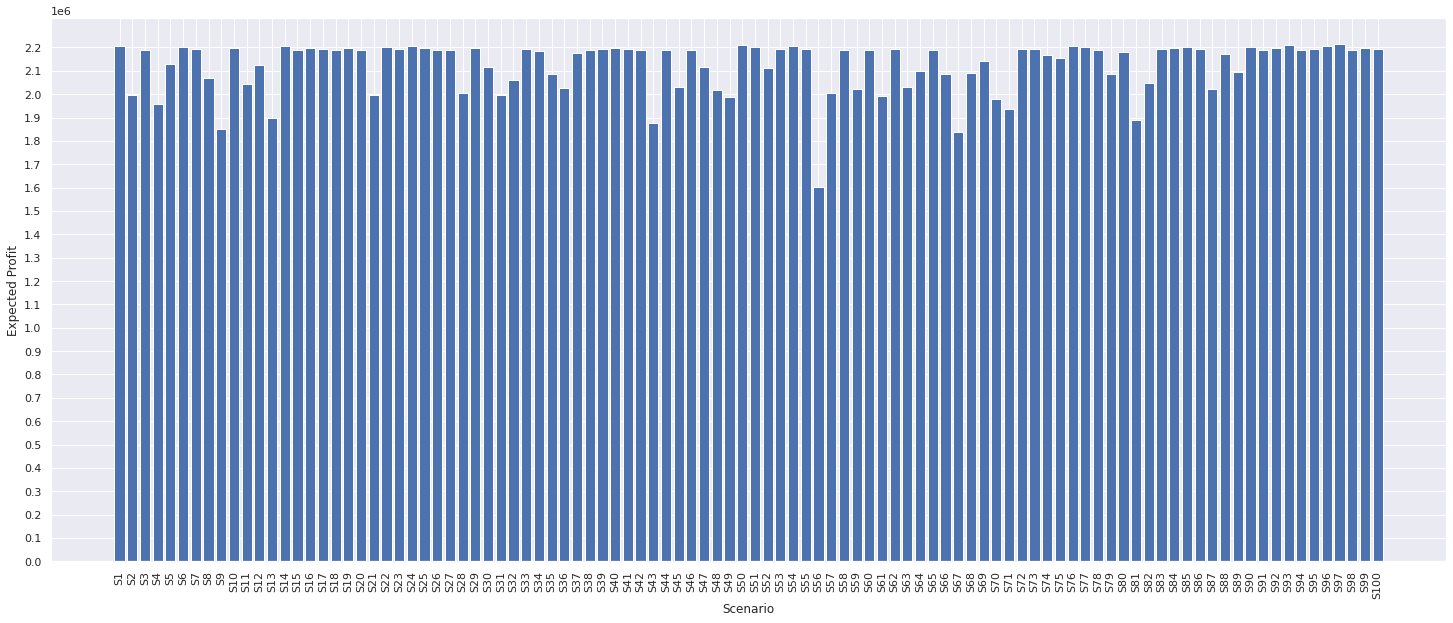

<IPython.core.display.Javascript object>

In [27]:
results = []
for k, v in WareHProd_mod.items():
    results.append([k, v.X])
w_WaretDis = pd.DataFrame(results).rename(columns={0: "Warehouse", 1: "WareDis"})

results = []
for k, v in dist_ware_scen.items():
    results.append([k[0], k[1], k[2], v.X])
d_WaretDis = pd.DataFrame(results).rename(
    columns={0: "Warehouse", 1: "Distribution Center", 2: "Scenario", 3: "WaretDis"}
)

dcost = []
for k, v in Trasnportation_Costs.items():
    dcost.append([k[0], k[1], v])
dcsot = pd.DataFrame(dcost).rename(
    columns={0: "Warehouse", 1: "Distribution Center", 2: "cost"}
)

results = []
for k, v in sold_distributioncentrer.items():
    results.append([k[0], k[1], v.X])
sold = pd.DataFrame(results, columns=["Distribution Center", "Scenario", "Sold"])

sold["revenue"] = sold.Sold * 20
sold = sold.groupby(["Scenario"]).revenue.sum().reset_index()

d_WaretDis = pd.merge(
    d_WaretDis, dcsot, on=["Warehouse", "Distribution Center"], how="left"
).rename(columns={0: "Warehouse", 1: "Distribution Center"})


d_WaretDis["distributon_cost"] = d_WaretDis.WaretDis * d_WaretDis.cost
d_WaretDis = d_WaretDis.groupby(["Scenario"]).distributon_cost.sum().reset_index()

expected_profit = pd.merge(
    left=sold, right=d_WaretDis, left_on="Scenario", right_on="Scenario"
)

expected_profit["expected_profit"] = (
    expected_profit.revenue
    - 100000
    - w_WaretDis.max()[1] * 0.35
    - expected_profit.distributon_cost
    - 2784410
)

expected_profit["numbers"] = expected_profit.Scenario.apply(
    lambda x: str(x).replace("S", "")
)
expected_profit = expected_profit.sort_values(by="numbers", ascending=True).reset_index(
    drop=True
)

expected_profit["numbers"] = expected_profit["numbers"].astype(int)
expected_profit.sort_values(by="numbers", ascending=True, inplace=True)

expected_profit.drop(columns=["numbers"], inplace=True)

fig, ax = plt.subplots(figsize=(25, 10))
sns.set_theme()

ax.bar(data=expected_profit, x="Scenario", height="expected_profit")
ax.set_yticks(
    np.arange(
        0,
        max(expected_profit["expected_profit"]) + 1,
        100000,
    )
)
plt.xticks(rotation=90)
ax.set_xlabel("Scenario")
ax.set_ylabel("Expected Profit")
# ax.legend()
plt.show()

In [28]:
expected_profit["FixedCosts"] = 100000
expected_profit["WarehouseCosts"] = w_WaretDis.max()[1] * 0.35
expected_profit["ProductionCosts"] = 278441 * 10
expected_profit["2nd_StageCosts"] = (
    expected_profit.revenue - expected_profit.distributon_cost
)

expected_profit[
    expected_profit.expected_profit == expected_profit.expected_profit.min()
]

,Scenario,revenue,distributon_cost,expected_profit,FixedCosts,WarehouseCosts,ProductionCosts,2nd_StageCosts
52,S56,4940660.0,356871.5,1601924.15,100000,97454.35,2784410,4583788.5


<IPython.core.display.Javascript object>

In [29]:
w_WaretDis

,Warehouse,WareDis
0,WH-Seville,0.0
1,WH-Rhodes,0.0
2,WH-Heraklion,0.0
3,WH-Stuttgart,278441.0
4,WH-Charleroi,0.0
5,WH-Bristol,0.0
6,WH-MÃ¡laga,0.0
7,WH-Moscow,0.0
8,WH-Glasgow,0.0
9,WH-Oslo,0.0


<IPython.core.display.Javascript object>

In [30]:
expected_profit[
    expected_profit.expected_profit == expected_profit.expected_profit.max()
]

,Scenario,revenue,distributon_cost,expected_profit,FixedCosts,WarehouseCosts,ProductionCosts,2nd_StageCosts
97,S97,5568820.0,370246.4,2216709.25,100000,97454.35,2784410,5198573.6


<IPython.core.display.Javascript object>



#### B3

In [31]:
TransportationCosts = pd.read_csv(
    "/home/angelo/Documents/Uni/Courses/Management Science/MS_Code_repo/data/TranportationCosts.csv",
    encoding="latin-1",
)
Demand = pd.read_csv(
    "/home/angelo/Documents/Uni/Courses/Management Science/MS_Code_repo/data/demand.csv",
    encoding="latin-1",
)
Scenario = Demand.columns[1:].to_list()
Scenario_Probabilities = dict(zip(Scenario, [1 / 100] * 100))


Distro = Demand.loc[:, "DistributionCenter"].to_list()
Warehouse = TransportationCosts.loc[:, "Warehouse"].to_list()

demand = {}
for distro in range(0, len(Demand)):
    for scene in range(1, len(Demand.columns)):
        demand[(Distro[distro], Scenario[scene - 1])] = Demand.loc[
            distro, Scenario[scene - 1]
        ]

Trasnportation_Costs = {}
for warehouse in range(0, len(TransportationCosts)):
    for distro in range(2, len(TransportationCosts.columns)):
        Trasnportation_Costs[
            (Warehouse[warehouse], Distro[distro - 2])
        ] = TransportationCosts.loc[warehouse, Distro[distro - 2]]

Transport_Warehouse = {}
for warehouse in range(0, len(TransportationCosts)):
    Transport_Warehouse[Warehouse[warehouse]] = TransportationCosts.loc[
        warehouse, "PFacility"
    ]


model = gp.Model()
model.ModelSense = gp.GRB.MAXIMIZE


# first stage
WareHProd_mod = model.addVars(Warehouse, vtype=gp.GRB.INTEGER, name="Production")
WareHInv_mod = model.addVars(Warehouse, vtype=gp.GRB.BINARY, name="Investment")

# second stage
dist_ware_scen = model.addVars(
    Warehouse, Distro, Scenario, vtype=gp.GRB.INTEGER, name="Transportation"
)

Inventory_Distr = model.addVars(
    Distro, Scenario, vtype=gp.GRB.INTEGER, name="Inventory"
)

sold_distributioncentrer = model.addVars(
    Distro, Scenario, vtype=gp.GRB.INTEGER, name="Sold"
)


# worst case profit
WorstCaseProfit = model.addVar(vtype=gp.GRB.INTEGER, name="WorstCaseProfit")


model.setObjective(
    -gp.quicksum(
        WareHProd_mod[warehouse] * (10 + Transport_Warehouse[warehouse])
        for warehouse in Warehouse
    )
    - gp.quicksum(WareHInv_mod[warehouse] * 100000 for warehouse in Warehouse)
    + WorstCaseProfit
)


# binary condition if they are turned on they can send
model.addConstrs(
    (
        gp.quicksum(dist_ware_scen[warehouse, distro, scene] for distro in Distro)
        <= WareHProd_mod[warehouse] * WareHInv_mod[warehouse]
        for scene in Scenario
        for warehouse in Warehouse
    ),
    name="SentProduction_Bin",
)

# inventory cannoth be greater than what you send there
model.addConstrs(
    (
        Inventory_Distr[distro, scene]
        == gp.quicksum(
            dist_ware_scen[warehouse, distro, scene] for warehouse in Warehouse
        )
        for scene in Scenario
        for distro in Distro
    ),
    name="Distr_Receive_Sent_limit",
)


model.addConstrs(
    (
        sold_distributioncentrer[distro, scene] <= demand[distro, scene]
        for scene in Scenario
        for distro in Distro
    ),
    name="Warehouse_Received_Demand_Limit",
)
model.addConstrs(
    (
        sold_distributioncentrer[distro, scene] <= Inventory_Distr[distro, scene]
        for scene in Scenario
        for distro in Distro
    ),
    name="Warehouse_Received_Demand_Limit",
)

# add the final constraint that to remove from the OBJ the second stage costs
# and only leave the first stage costs + WP in the objective
for scene in Scenario:
    model.addConstr(
        WorstCaseProfit
        <= gp.quicksum(
            20 * sold_distributioncentrer[distro, scene] for distro in Distro
        )
        - gp.quicksum(
            dist_ware_scen[warehouse, distro, scene]
            * Trasnportation_Costs[warehouse, distro]
            for distro in Distro
            for warehouse in Warehouse
        )
    )

model.optimize()
print("Optimal Value:", model.Objval)

# model.printAttr("X")

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 12400 rows, 102547 columns and 209200 nonzeros
Model fingerprint: 0x3e002ad3
Model has 2300 quadratic constraints
Variable types: 0 continuous, 102547 integer (23 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+02, 4e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 5900 rows and 4077 columns
Presolve time: 0.54s
Presolved: 6569 rows, 98539 columns, 293661 nonzeros
Presolved model has 46 SOS constraint(s)
Variable types: 0 continuous, 98539 integer (46 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log o

<IPython.core.display.Javascript object>

In [32]:
1926996.45 - 2124910.46

-197914.01

<IPython.core.display.Javascript object>

In [33]:
output_dict = {}
for i_x, variable_o in dist_ware_scen.items():
    output_dict[i_x] = variable_o.x

df_vals = pd.DataFrame([key + (var,) for key, var in output_dict.items()],).rename(
    columns={0: "Warehouse", 1: "DistributionCenter", 2: "Scenario", 3: "Volumne_Sent"}
)

df_stut = df_vals.loc[df_vals["Warehouse"].str.contains("Stuttgart")]

<IPython.core.display.Javascript object>

In [34]:
stuttgart = []
for _, value in Trasnportation_Costs.keys():
    stuttgart.append(Trasnportation_Costs["WH-Stuttgart", value])

round(np.sum(stuttgart) / len(stuttgart), 4)

1.5488

<IPython.core.display.Javascript object>

In [35]:
df = pd.DataFrame([key + (var,) for key, var in Trasnportation_Costs.items()]).rename(
    columns={0: "Warehouse", 1: "DistributionCenter", 2: "Cost"}
)
df.groupby("Warehouse").agg({"Cost": "mean"}).sort_values("Cost")

,Cost
Warehouse,
WH-Stuttgart,1.548780
WH-Charleroi,1.558537
WH-Bordeaux,1.673171
WH-Bristol,1.682927
WH-KrakÃ³w,1.734146
WH-Palma de Mallorca,1.795122
WH-Glasgow,1.814634
WH-Oslo,1.846341
WH-Hanover,1.860976


<IPython.core.display.Javascript object>

In [36]:
Demand.iloc[:, 1:].mean(axis=1).sum()

281633.11

<IPython.core.display.Javascript object>

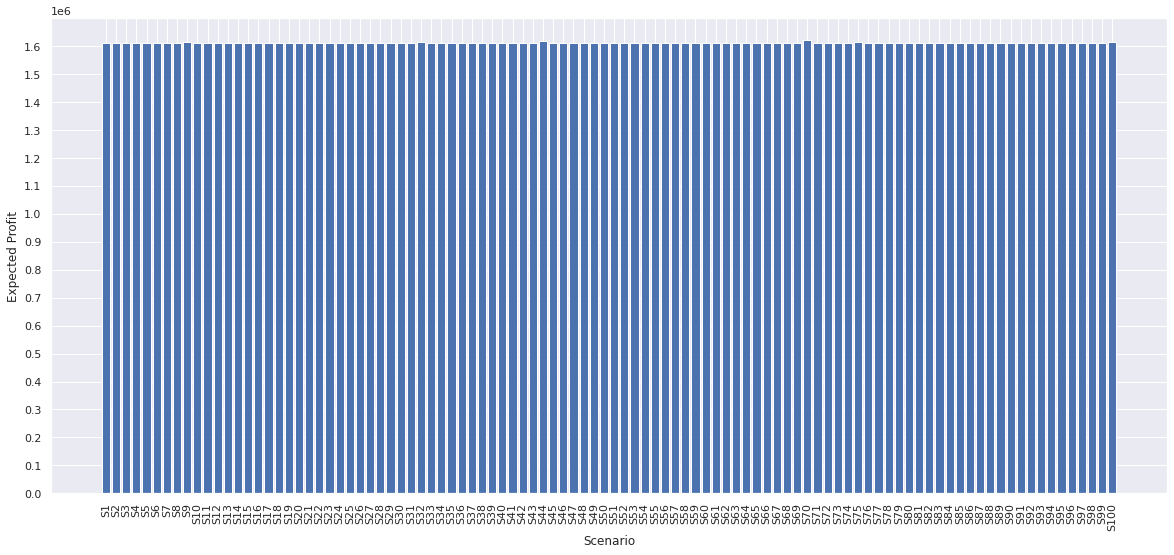

<IPython.core.display.Javascript object>

In [37]:
results = []
for k, v in WareHProd_mod.items():
    results.append([k, v.X])
w_WaretDis = pd.DataFrame(results).rename(columns={0: "Warehouse", 1: "WareDis"})

results = []
for k, v in dist_ware_scen.items():
    results.append([k[0], k[1], k[2], v.X])
d_WaretDis = pd.DataFrame(results).rename(
    columns={0: "Warehouse", 1: "Distribution Center", 2: "Scenario", 3: "WaretDis"}
)

dcost = []
for k, v in Trasnportation_Costs.items():
    dcost.append([k[0], k[1], v])
dcsot = pd.DataFrame(dcost).rename(
    columns={0: "Warehouse", 1: "Distribution Center", 2: "cost"}
)

results = []
for k, v in sold_distributioncentrer.items():
    results.append([k[0], k[1], v.X])
sold = pd.DataFrame(results, columns=["Distribution Center", "Scenario", "Sold"])

sold["revenue"] = sold.Sold * 20
sold = sold.groupby(["Scenario"]).revenue.sum().reset_index()

d_WaretDis = pd.merge(
    d_WaretDis, dcsot, on=["Warehouse", "Distribution Center"], how="left"
).rename(columns={0: "Warehouse", 1: "Distribution Center"})


d_WaretDis["distributon_cost"] = d_WaretDis.WaretDis * d_WaretDis.cost
d_WaretDis = d_WaretDis.groupby(["Scenario"]).distributon_cost.sum().reset_index()

expected_profit = pd.merge(
    left=sold, right=d_WaretDis, left_on="Scenario", right_on="Scenario"
)

expected_profit["expected_profit"] = (
    expected_profit.revenue
    - 100000
    - w_WaretDis.max()[1] * 0.35
    - expected_profit.distributon_cost
    - 2784410
)

expected_profit["numbers"] = expected_profit.Scenario.apply(
    lambda x: str(x).replace("S", "")
)
expected_profit = expected_profit.sort_values(by="numbers", ascending=True).reset_index(
    drop=True
)

expected_profit["numbers"] = expected_profit["numbers"].astype(int)
expected_profit.sort_values(by="numbers", ascending=True, inplace=True)

expected_profit.drop(columns=["numbers"], inplace=True)

fig, ax = plt.subplots(figsize=(20, 8.75))
sns.set_theme()

ax.bar(data=expected_profit, x="Scenario", height="expected_profit")

ax.set_yticks(
    np.arange(
        0,
        max(expected_profit["expected_profit"]) + 1,
        100000,
    )
)
plt.xticks(rotation=90)
ax.set_xlabel("Scenario")
ax.set_ylabel("Expected Profit")

# ax.legend()
plt.show()

In [38]:
w_WaretDis

,Warehouse,WareDis
0,WH-Seville,-0.0
1,WH-Rhodes,0.0
2,WH-Heraklion,-0.0
3,WH-Stuttgart,247033.0
4,WH-Charleroi,-0.0
5,WH-Bristol,-0.0
6,WH-MÃ¡laga,-0.0
7,WH-Moscow,-0.0
8,WH-Glasgow,-0.0
9,WH-Oslo,-0.0


<IPython.core.display.Javascript object>

In [39]:
len(
    np.arange(
        0,
        max(expected_profit["expected_profit"]) + 1,
        100000,
    )
)

17

<IPython.core.display.Javascript object>

In [40]:
expected_profit["FixedCosts"] = 100000
expected_profit["WarehouseCosts"] = w_WaretDis.max()[1] * 0.35
expected_profit["ProductionCosts"] = 278441 * 10
expected_profit["2nd_StageCosts"] = (
    expected_profit.revenue - expected_profit.distributon_cost
)

print(
    expected_profit[
        expected_profit.expected_profit == expected_profit.expected_profit.min()
    ].to_latex(index=False, multirow=True)
)

\begin{tabular}{lrrrrrrr}
\toprule
Scenario &   revenue &  distributon\_cost &  expected\_profit &  FixedCosts &  WarehouseCosts &  ProductionCosts &  2nd\_StageCosts \\
\midrule
     S56 & 4940660.0 &          356871.5 &       1612916.95 &      100000 &        86461.55 &          2784410 &       4583788.5 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_67036/2531812867.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  expected_profit[


<IPython.core.display.Javascript object>